# **Projekt PRiAD 2023Z**
### **Temat:**
Przewidywanie cen domów (regresja)

### **Autorzy:**
* Adrian Chmiel *(325453)*
* Maciej Staszczyk *(325516)*

**Wydział Elektryczny** \
**Kierunek:** Informatyka Stosowana

## 1. Import potrzebnych bibliotek

Przed rozpoczęciem pracy nad naszym zbiorem danych potrzebne jest zaimportowanie wszelkich bibliotek i funkcji, z 
których będziemy korzystać. Wykorzystane biblioteki obejmują:
* **matplotlib** - odpowiedzialna za tworzenie wykresów
* **seaborn** - również pomaga w tworzeniu wykresów i wizualizacji danych
* **numpy** - ułatwia wykonywanie obliczeń na macierzach i wektorach
* **pandas** - służy do analizy oraz przetwarzania danych
* **tensorflow** - biblioteka do tworzenia modeli uczenia maszynowego

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Załadowanie danych

Po zaimportowaniu bibliotek możemy przejść do wczytania danych do naszego dataframe. W tym celu posłuży nam plik *housing_price_dataset.csv* zawierający wszelkie potrzebne nam dane. Od razu po tym wykonujemy kopię zbioru korzystając z funkcji **copy()** tak, aby mieć możliwość powrotu do oryginału w razie potrzeby. Następnie wykonujemy parę operacji, które pozwolą nam poznać nasze dane:
* **head()** - wyświetla pierwsze 5 wierszy naszego zbioru danych
* **describe()** - wyświetla podstawowe statystyki opisane w tabeli poniżej
* **info()** - wyświetla podstawowe informacje o zbiorze danych oraz typach danych w poszczególnych kolumnach

| ***Statystyka*** | ***Opis***                                                                  |
|------------------|:----------------------------------------------------------------------------|
| **count**        | liczba wartości w danej kolumnie                                            |
| **mean**         | średnia arytmetyczna wartości w kolumnie                                    |
| **std**          | odchylenie standardowe, miara rozproszenia danych                           |
| **min**          | najmniejsza wartość w kolumnie                                              |
| **25%**          | pierwszy kwartyl tj. wartość poniżej której znajduje się 25% wartości       |
| **50%**          | drugi kwartyl, mediana tj. wartość poniżej której znajduje się 50% wartości |
| **75%**          | trzeci kwartyl tj. wartość poniżej której znajduje się 75% wartości         |
| **max**          | największa wartość w kolumnie                                               |

In [72]:
raw_dataset = pd.read_csv('housing_price_dataset.csv')
dataset = raw_dataset.copy()

In [73]:
dataset.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [74]:
dataset.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [75]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


Przed przejściem do kolejnego kroku sprawdzamy, czy w zbiorze nie ma wartości pustych lub duplikatów.

In [76]:
print("Duplicated: ", dataset.duplicated().sum())
print("Missing/incomplete: ", dataset.isnull().sum().sum())

Duplicated:  0
Missing/incomplete:  0


Takowe wartości nie występują, a więc nie jest konieczne ich usuwanie.

## 3. Wizualizacja danych

Pierwszym krokiem będzie **sprawdzenie rozkładu danych** w poszczególnych kolumnach. W tym celu wykorzystamy **wykresy histogramów**.

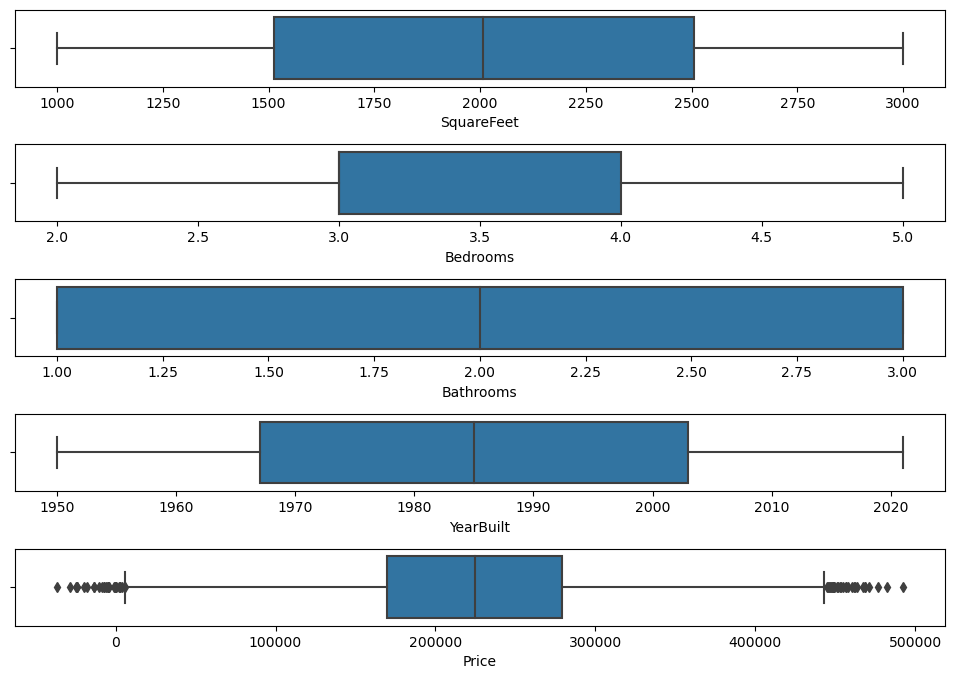

In [77]:
columns_names = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'Price']

fig, ax = plt.subplots(len(columns_names), 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.75)

for i in range(len(columns_names)):
    sns.boxplot(x=columns_names[i], data=raw_dataset, ax=ax[i])

plt.show()

Pierwsze, co wyraźnie rzuca się w oczy to **ujemne wartości** w kolumnie Price. Zobaczmy, ile jest tych wartości.

In [78]:
negative_price_count = dataset[dataset['Price'] < 0].count()['Price']
print("Negative 'Price' values: ", negative_price_count)

Negative 'Price' values:  22


Wartości te zostały uznane przez nas za **niepoprawne**, dlatego zostaną **usunięte** z datasetu w następnym kroku. Dzięki temu nie zostaną one uwzględnione w dalszej analizie.

Dropped negative values in 'Price' column.


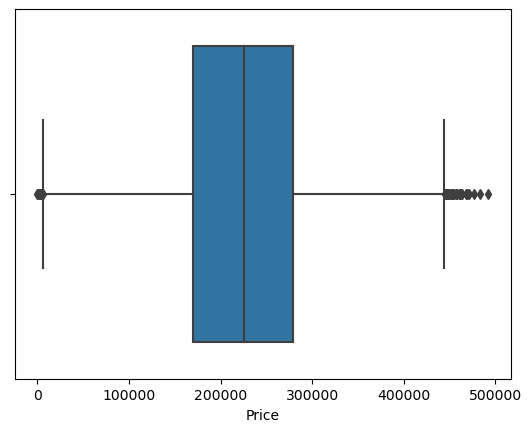

In [79]:
dataset = dataset[dataset['Price'] >= 0]
sns.boxplot(x="Price", data=dataset)
print("Dropped negative values in 'Price' column.")

Następnym krokiem będzie sprawdzenie ilości **unikalnych wartości** w poszczególnych kolumnach zbioru danych.

In [80]:
for column in dataset.columns:
    num_distinct_values = len(dataset[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

SquareFeet: 2000 distinct values
Bedrooms: 4 distinct values
Bathrooms: 3 distinct values
Neighborhood: 3 distinct values
YearBuilt: 72 distinct values
Price: 49978 distinct values


Teraz sprawdzamy, które kolumny są **numeryczne** tj. które kolumny zawierają wartości liczbowe.

In [81]:
numeric_columns = dataset.select_dtypes(['int64','float64'])
print('Numeric columns: ', numeric_columns.columns.tolist())

Numeric columns:  ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'Price']


W oparciu o powyższą listę sprawdzamy zależności między **kolumnami numerycznymi a kosztem**. W tym celu wykonamy wykresy punktowe, które świetnie nam to zobrazują.

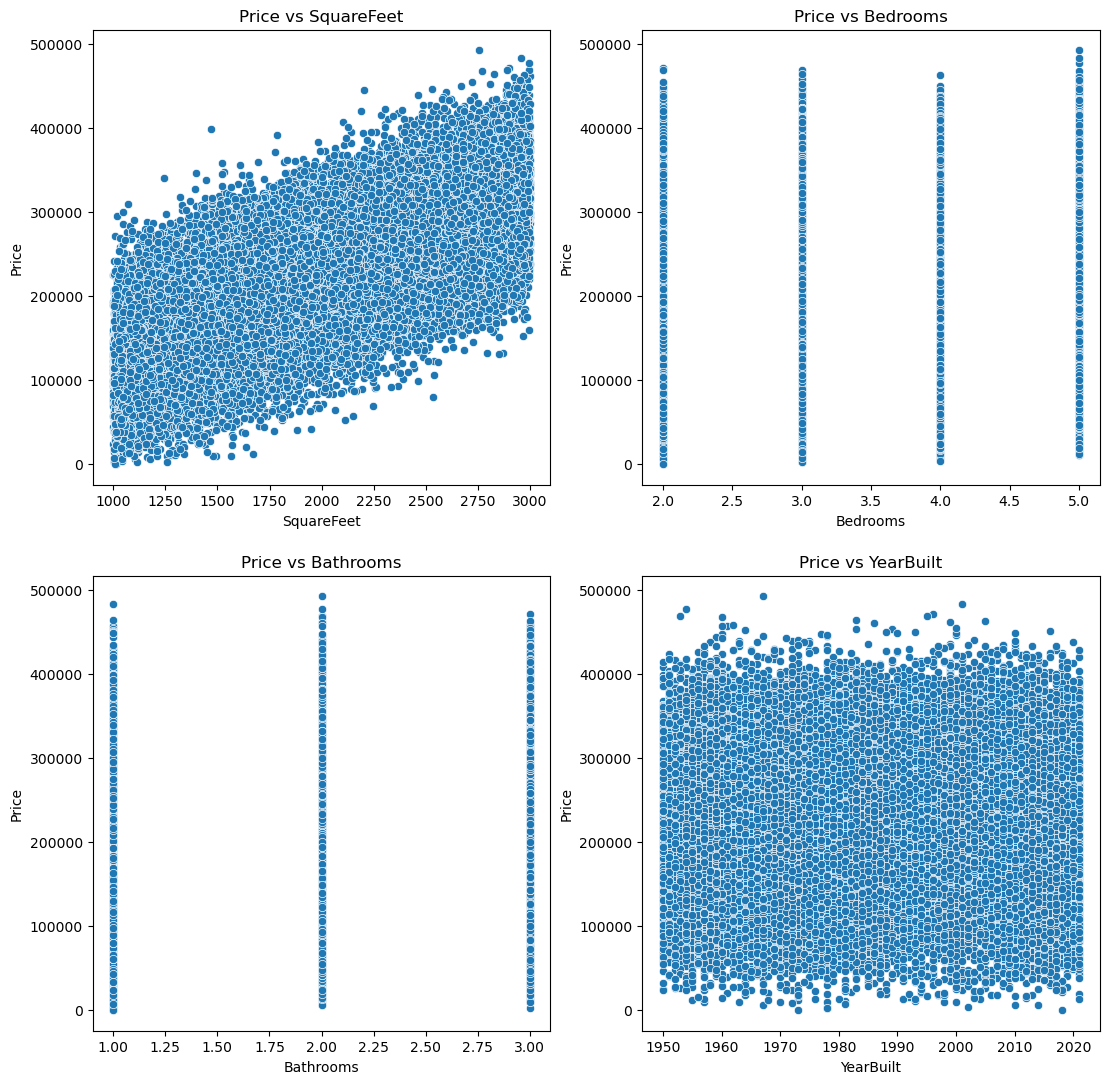

In [82]:
plt.figure(figsize=(13, 13))

for i, variable in enumerate(numeric_columns):
    if variable == 'Price': continue
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=dataset[variable], y=dataset['Price'])
    plt.title('Price vs ' + variable)

plt.show()

Na pierwszy rzut oka możemy zauważyć, że kolumna SquareFeet ma największy wpływ na cenę mieszkania. Pozostałe dane nie wykazują żadnej korelacji, która mogłaby być dla nas istotna.

## 4. Przygotowanie i normalizacja danych

Pierwszym etapem przygotowania danych będzie **One-Hot Encoding**. Jest to technika przekształcania **kategorialnych** danych na **formę numeryczną**, która jest **łatwiejsza do przetworzenia** przez algorytmy uczenia maszynowego.

W tym celu wykorzystamy funkcję **get_dummies()**. Dzięki niej każda unikalna wartość w kolumnie Neighborhood zostanie zamieniona na osobną kolumnę, która będzie zawierała wartość *True* (1) albo *False* (0) w zależności od tego, czy dany wiersz zawierał daną wartość.

*Przykład:*
Neighborhood: 'Rural' -> Neighborhood_Rural: 1, Neighborhood_Suburban: 0, Neighborhood_Urban: 0

Po wykonaniu tej funkcji łączymy nasz zbiór danych z nowymi osobnymi kolumnami, które zawierają wartości zwrócone przez funkcję **get_dummies()**. Kolumna 'Neighborhood' zostaje usunięta, ponieważ nie będzie ona już nam potrzebna po takim przetworzeniu.

In [83]:
one_hot = pd.get_dummies(dataset['Neighborhood'], prefix='Neighborhood')
dataset = pd.concat([dataset, one_hot], axis=1)
dataset = dataset.drop('Neighborhood', axis=1)
dataset.head()
print("One-hot encoding successful.")

One-hot encoding successful.


Kolejnym krokiem jest utworzenie treningowego i testowego zbioru danych. W tym celu wykorzystamy funkcję **sample()**, która losowo wybierze 80% wierszy z naszego zbioru danych i utworzy z nich zbiór treningowy. Wybrane wiersze dodatkowo zostają przemieszane poprzez reorganizację indeksów w inną losową permutację.

Parametr **random_state** jest nasieniem generatora liczb pseudolosowych, który zapewnia, że za każdym razem, gdy uruchomimy nasz program, otrzymamy **ten sam podzbiór** danych. Nie jest on konieczny, lecz wykorzystanie tych samych danych ułatwia pracę nad poprawą dokładności modelu.

Pozostałe 20% wierszy zostanie wykorzystane do utworzenia zbioru testowego.

In [84]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_dataset = train_dataset.reindex(np.random.permutation(train_dataset.index))

test_dataset = dataset.drop(train_dataset.index)

Następnym krokiem jest **zdefiniowanie i normalizacja danych wejściowych** oraz przygotowanie **warstw preprocessingu** dla naszego modelu. 

Normalizacja polega na **przeskalowaniu** wartości w kolumnach tak, aby wszystkie wartości mieściły się w przedziale **od 0 do 1**. Dzięki temu nasz model będzie mógł łatwiej nauczyć się **zależności** między danymi wyrażonymi w niejednolity sposób.

Po normalizacji każdej z kolumn dokonujemy ich **konkatenacji** tj. łączymy je w jedną warstwę.

In [85]:
columns_to_normalize = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt']
inputs, normalized = {}, []
    
for column in one_hot.columns:
    inputs[column] = tf.keras.layers.Input(name=column, shape=(1,), dtype='int64')

for column in columns_to_normalize:
    inputs[column] = tf.keras.layers.Input(name=column, shape=(1,), dtype='int64')
    normalization_layer = tf.keras.layers.Normalization(name='normalization_' + column, axis=None)
    normalization_layer.adapt(np.array(train_dataset[column]))
    normalized.append(normalization_layer(inputs[column]))

preprocessing_layers = tf.keras.layers.Concatenate()(normalized)

print("Preprocessing layers defined.")

Preprocessing layers defined.


## 5. Tworzenie modelu

Pierwszym etapem jest zdefiniowanie funkcji pomocniczej, która będzie nam służyć do tworzenia wykresów przedstawiających **błąd modelu** w zależności od **liczby epok**. Dzięki temu będziemy mogli zobrazować sobie wartości **funkcji straty** oraz sprawdzić, czy nasz model się **przeucza** lub **niedoucza**. Argumenty tej funkcji to odpowiednio:
* **epochs** - liczba epok
* **mse_training** - wartość błędu średniokwadratowego dla zbioru treningowego
* **mse_validation** - wartość błędu średniokwadratowego dla zbioru walidacyjnego

In [86]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


Następnie tworzymy funkcję odpowiedzialną za utworzenie modelu. Przyjmuje ona następujące argumenty:
* **my_inputs** - warstwy wejściowe modelu
* **my_outputs** - warstwy wyjściowe modelu
* **my_learning_rate** - współczynnik uczenia

W tej funkcji tworzymy model, który składa się z warstw wejściowych i wyjściowych. Następnie kompilujemy go, ustawiając optymalizator, funkcję straty oraz metryki, które będą nam potrzebne do oceny modelu. Na koniec zwracamy utworzony model.

Optymalizator **Adam** *(Adaptive Moment Estimation)*, użyty w tym modelu, jest zaawansowanym algorytm optymalizacji używanym w treningu modeli maszynowych. Charakteryzuje się adaptacyjnym tempem uczenia, wykorzystaniem momentu, średnią ruchomą kwadratu gradientu oraz mechanizmem bias korekcyjnym. Jest to dosyć powszechnie stosowany model ze względu na swoją skuteczność, uniwersalność i łatwość użycia.

In [87]:
def create_model(my_inputs, my_outputs, my_learning_rate):
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])
  
  return model

print("Defined the create_model function.")

Defined the create_model function.


Kolejnym krokiem jest zdefiniowanie funkcji, która będzie służyć do trenowania modelu. Przyjmuje ona następujące argumenty:
* **model** - model, który chcemy trenować
* **dataset** - zbiór danych, na którym chcemy trenować model
* **epochs** - liczba epok
* **batch_size** - rozmiar paczki danych treningowych
* **label_name** - nazwa kolumny, która będziemy "przewidywać"
* **validation_split** - procent danych treningowych, który zostanie wykorzystany do walidacji modelu

Funkcja na początku tworzy słownik **cech** oraz wydziela **etykietę**. Następnie w oparciu o podane argumenty trenuje model i zwraca informacje, które będą nam potrzebne do stworzenia wykresu błędu.

In [88]:
def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_price_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the train_model function.")

Defined the train_model function.


Następnie normalizuję etykietę tj. kolumnę 'Price' zarówno dla danych treningowych, jak i testowych. Jednakże nie zostają one dodane do modelu, ponieważ są to etykiety, które chcemy, aby on przewidział.

In [89]:
train_price_normalized = tf.keras.layers.Normalization(axis=None)
train_price_normalized.adapt(
    np.array(train_dataset['Price']))

test_price_normalized = tf.keras.layers.Normalization(axis=None)
test_price_normalized.adapt(
    np.array(test_dataset['Price']))

Ostatnia funkcja, którą zdefiniujemy, będzie służyć do **wyświetlania wyników**. Tworzy ona gęstą warstwę o jednym neuronie, co jest charakterystyczne dla regresji liniowej, bazując na danych z warstw preprocessingu.

In [90]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

W końcu przechodzimy do momentu uruchomienia modelu regresji liniowej. W tym celu wykorzystujemy wszystkie zdefiniowane wyżej funkcje. Spośród nieporuszanych wcześniej rzeczy warto zwrócić uwagę na dwa ostatnie segmenty kodu. Istotne jest, aby przygotować odpowiednio dane testowe poprzez ucięcie kolumny 'Price', którą będziemy przewidywać. Następnie model dokonuje oceny i wyświetlany jest końcowy rezultat. 

Epoch 1/15
64/64 [==============================] - 2s 17ms/step - loss: 3.2608 - mean_squared_error: 3.2608 - val_loss: 1.8708 - val_mean_squared_error: 1.8708
Epoch 2/15
64/64 [==============================] - 0s 6ms/step - loss: 1.2527 - mean_squared_error: 1.2527 - val_loss: 0.8541 - val_mean_squared_error: 0.8541
Epoch 3/15
64/64 [==============================] - 0s 5ms/step - loss: 0.6606 - mean_squared_error: 0.6606 - val_loss: 0.5420 - val_mean_squared_error: 0.5420
Epoch 4/15
64/64 [==============================] - 0s 6ms/step - loss: 0.4852 - mean_squared_error: 0.4852 - val_loss: 0.4528 - val_mean_squared_error: 0.4528
Epoch 5/15
64/64 [==============================] - 0s 5ms/step - loss: 0.4415 - mean_squared_error: 0.4415 - val_loss: 0.4325 - val_mean_squared_error: 0.4325
Epoch 6/15
64/64 [==============================] - 0s 5ms/step - loss: 0.4334 - mean_squared_error: 0.4334 - val_loss: 0.4287 - val_mean_squared_error: 0.4287
Epoch 7/15
64/64 [=====================

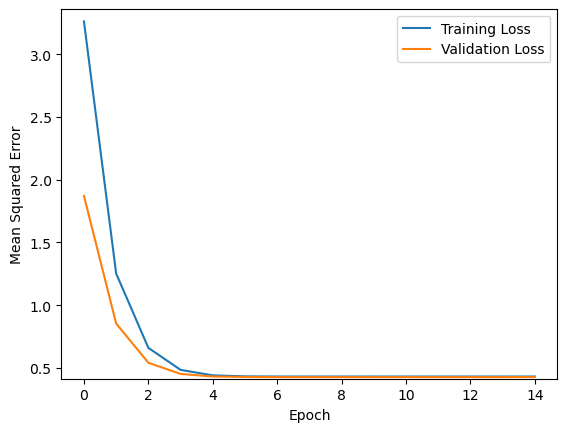


 Evaluate the linear regression model against the test set:
20/20 [==============================] - 0s 3ms/step - loss: 0.4274 - mean_squared_error: 0.4274


{'loss': 0.4274017810821533, 'mean_squared_error': 0.4274017810821533}

In [91]:
learning_rate = 0.01
epochs = 15
batch_size = 500
label_name = "Price"
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_dataset, epochs, batch_size,
                                   label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name: np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(test_features.pop(label_name))  # isolate the label

print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size, return_dict=True)

## 6. Tworzenie głębokiej sieci neuronowej
W tym kroku utworzymy **głęboką sieć neuronową**, która będzie w stanie uczyć się na podstawie podanych danych. 
Osiągniemy to poprzez utworzenie dwóch dodatkowych warstw z odpowiednio 20 i 12 węzłami oraz funkcją aktywacji **ReLU**.

Funkcja ta zwraca `f(x) = max(0, x)` oraz ma zastosowanie w przypadku, gdy chcemy, aby nasz model mógł nauczyć się **nieliniowych zależności** w danych. Jej prostota pozwala na szybkie obliczenia, a także zapobiega zanikaniu gradientu. Dzięki temu jest jedną z najczęściej stosowanych funkcji aktywacji w głębokich sieciach neuronowych.

In [92]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

Epoch 1/20
32/32 [==============================] - 4s 24ms/step - loss: 0.5407 - mean_squared_error: 0.5407 - val_loss: 0.4434 - val_mean_squared_error: 0.4434
Epoch 2/20
32/32 [==============================] - 0s 8ms/step - loss: 0.4385 - mean_squared_error: 0.4385 - val_loss: 0.4311 - val_mean_squared_error: 0.4311
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.4353 - mean_squared_error: 0.4353 - val_loss: 0.4307 - val_mean_squared_error: 0.4307
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 0.4335 - mean_squared_error: 0.4335 - val_loss: 0.4306 - val_mean_squared_error: 0.4306
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.4336 - mean_squared_error: 0.4336 - val_loss: 0.4292 - val_mean_squared_error: 0.4292
Epoch 6/20
32/32 [==============================] - 0s 13ms/step - loss: 0.4349 - mean_squared_error: 0.4349 - val_loss: 0.4304 - val_mean_squared_error: 0.4304
Epoch 7/20
32/32 [====================

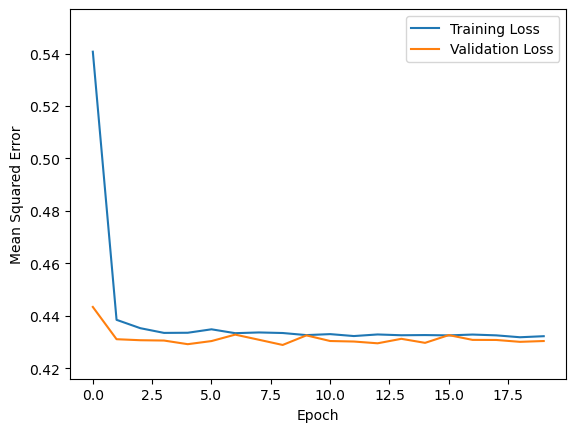


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 4ms/step - loss: 0.4282 - mean_squared_error: 0.4282


{'loss': 0.42822542786598206, 'mean_squared_error': 0.42822542786598206}

In [93]:
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = "Price"
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_dataset, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_dataset.items()}
test_label = test_price_normalized(np.array(test_features.pop(label_name))) # isolate the label

print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## 7. Podsumowanie


https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/programming-exercise?hl=en

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en

https://www.kaggle.com/code/alkidiarete/housing-price-prediction-h2o-ai-automl/notebook

https://www.tensorflow.org/tutorials/keras/regression?hl=pl